In [307]:
import pandas as pd
from uszipcode import SearchEngine # us zipcodes library to get latitude and longitude for distance calculation
import mpu   #determines the great-circle distance between two points on a sphere.
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Import label encoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

# Data exploration

In [308]:
df = pd.read_csv('order_records.csv')

In [309]:
df.drop(df.columns[0], axis = 1, inplace=True) #dropping the extra column with row count inplace

In [310]:
df.info() # checking for data type of columns and existence of nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ORDER_ID      10000 non-null  int64  
 1   COMPANY_ID    10000 non-null  int64  
 2   SERVICE_LINE  10000 non-null  int64  
 3   DRIVER_TYPE   10000 non-null  object 
 4   WEIGHT_LBS    10000 non-null  float64
 5   VOLUME_IN3    10000 non-null  float64
 6   EXPENSE       10000 non-null  float64
 7   PICKUP_ZIP    10000 non-null  object 
 8   DELIVERY_ZIP  10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 703.2+ KB


In [311]:
df.tail()

,ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP
9995,109996,573,1,commander,1.0,1.0,0.00,92562,92562
9996,109997,1056,1,commander,1.0,1.0,21.87,91730,91766
9997,109998,573,1,agent,1.0,1.0,0.00,92376,92880
9998,109999,14,1,commander,10.0,3520.0,91.68,20166,20109
9999,110000,157,1,commander,40.0,1.0,184.56,31903,31707


Feature Extraction

In [312]:
search = SearchEngine(simple_zipcode=True)
def zip_to_lat_long(zip):  # zip code to state, city, county
    zip1 = search.by_zipcode(zip)
    return [zip1.lat, zip1.lng], zip1.major_city, zip1.county, zip1.state

def distance_calc(pick_up, delivery):   # distance calculated from lat and long coordinates
    output = []
    for i in range(len(pick_up)):
        pickup_lat, pickup_long = list(pick_up)[i][0], list(pick_up)[i][1]
        deliv_lat, deliv_long = list(delivery)[i][0], list(delivery)[i][1]
        try:
            dist = round(mpu.haversine_distance((pickup_lat, pickup_long), (deliv_lat, deliv_long)), 2)
            dist*=0.62137119
            output.append(round(dist, 2))
        except TypeError:
            output.append(-1)
    return pd.Series(output)

In [ ]:
# new features using the above methods

df['pick_up_coordinates'], df['pickup_city'], df['pickup_county'], df['pickup_state'] = zip(*df['PICKUP_ZIP'].apply(zip_to_lat_long))
df['deliv_coordinates'],  df['deliv_city'], df['deliv_county'], df['deliv_state'] = zip(*df['DELIVERY_ZIP'].apply(zip_to_lat_long))
df['distance'] = distance_calc(df['pick_up_coordinates'], df['deliv_coordinates'])
df['same_state'] = df['pickup_state'] == df['deliv_state']
df.head()

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ORDER_ID             10000 non-null  int64  
 1   COMPANY_ID           10000 non-null  int64  
 2   SERVICE_LINE         10000 non-null  int64  
 3   DRIVER_TYPE          10000 non-null  object 
 4   WEIGHT_LBS           10000 non-null  float64
 5   VOLUME_IN3           10000 non-null  float64
 6   EXPENSE              10000 non-null  float64
 7   PICKUP_ZIP           10000 non-null  object 
 8   DELIVERY_ZIP         10000 non-null  object 
 9   pick_up_coordinates  10000 non-null  object 
 10  pickup_city          9844 non-null   object 
 11  pickup_county        9844 non-null   object 
 12  pickup_state         9844 non-null   object 
 13  deliv_coordinates    10000 non-null  object 
 14  deliv_city           9901 non-null   object 
 15  deliv_county         9901 non-null   

In [315]:
df.describe() #summarizing the numerical and object series 

,ORDER_ID,COMPANY_ID,SERVICE_LINE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,distance
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,105000.50000,723.491700,1.044800,73.550117,5390.183335,121.593765,52.405417
std,2886.89568,375.894039,0.206875,5000.884862,31022.323197,193.312309,85.435098
min,100001.00000,9.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
25%,102500.75000,435.000000,1.000000,1.000000,1.000000,32.100000,7.280000
50%,105000.50000,680.000000,1.000000,2.000000,216.000000,59.200000,20.180000
75%,107500.25000,1045.000000,1.000000,16.000000,2496.000000,137.350000,66.470000
max,110000.00000,1351.000000,2.000000,500000.000000,975240.000000,5014.000000,1949.580000


In [316]:
df.shape

(10000, 19)

In [317]:
def outlier_detection(column):
    # This value/score helps to understand that how far is the data point from the mean.
    # And after setting up a threshold value one can utilize z score values of data points to define the outliers.
    # Zscore = (data_point -mean) / std. deviation
    # Now to define an outlier threshold value is chosen which is generally 3.0.
    # As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).
    z = np.abs(stats.zscore(column))
    threshold = 3
    return np.where(z>3)

In [318]:
weight_outliers = outlier_detection(df['WEIGHT_LBS'])

In [319]:
df.iloc[weight_outliers]

,ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP,pick_up_coordinates,pickup_city,pickup_county,pickup_state,deliv_coordinates,deliv_city,deliv_county,deliv_state,distance,same_state
5000,105002,371,1,agent,500000.0,2.0,55.08,95901,95965,"(39.2, -121.5)",Marysville,Yuba County,CA,"(39.6, -121.6)",Oroville,Butte County,CA,28.15,True


In [320]:
df.drop(index = 5000, inplace = True)

In [321]:
df.shape

(9999, 19)

In [322]:
df.to_csv('transformed_orders.csv')  #taking data out for visualizations in tableau

In [323]:
df.groupby('COMPANY_ID')['ORDER_ID'].count().reset_index().sort_values(by = 'ORDER_ID', ascending = False)

,COMPANY_ID,ORDER_ID
77,573,685
145,980,573
168,1127,398
97,667,364
50,371,346
...,...,...
94,661,1
188,1190,1
88,607,1
85,592,1


In [324]:
df.groupby('DRIVER_TYPE')['WEIGHT_LBS'].mean()

DRIVER_TYPE
agent        43.206264
commander    11.371133
Name: WEIGHT_LBS, dtype: float64

In [325]:
df.groupby('DRIVER_TYPE')['EXPENSE'].mean()

DRIVER_TYPE
agent        165.471942
commander     94.409026
Name: EXPENSE, dtype: float64

In [326]:
df.groupby('DRIVER_TYPE')['distance'].mean()

DRIVER_TYPE
agent        61.032154
commander    47.062530
Name: distance, dtype: float64

# Data Prepocessing

In [327]:
Y = df['EXPENSE']  #response variable

In [328]:
X = df[['COMPANY_ID', 'SERVICE_LINE', 'DRIVER_TYPE' , 'WEIGHT_LBS', 'VOLUME_IN3', 'PICKUP_ZIP', 'DELIVERY_ZIP', 'distance',
       'same_state']]     #independent variables

In [329]:
len(X['PICKUP_ZIP'].unique()), X['DRIVER_TYPE'].unique()

(1484, array(['commander', 'agent'], dtype=object))

In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
X['DRIVER_TYPE_N']= label_encoder.fit_transform(X['DRIVER_TYPE'])
X['same_state_N']= label_encoder.fit_transform(X['same_state'])
X['PICKUP_ZIP_LABEL'] = label_encoder.fit_transform(X['PICKUP_ZIP'])
X['DELIVERY_ZIP_LABEL'] = label_encoder.fit_transform(X['DELIVERY_ZIP'])


In [ ]:
X.drop(['DRIVER_TYPE', 'PICKUP_ZIP', 'DELIVERY_ZIP', 'same_state'], axis = 1, inplace=True)
X.head()  #final dataset for ML

In [332]:
Y.head()

0    304.93
1    354.10
2    306.83
3     36.83
4    611.27
Name: EXPENSE, dtype: float64

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Random Forest Regressor

In [334]:
#Create a Gaussian Classifier
regressor=RandomForestRegressor(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
regressor.fit(X_train,y_train)
#predict the test dataset
y_pred=regressor.predict(X_test)

In [335]:
#creating a dataset with real values and predicted values
resulting = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
resulting.reset_index(inplace=True)
resulting

,index,Real Values,Predicted Values
0,1840,99.61,93.639200
1,587,48.16,37.366641
2,9097,71.59,47.313190
3,4547,51.20,33.672814
4,3726,57.82,47.139621
...,...,...,...
1995,7732,292.89,309.998200
1996,5712,26.95,46.215142
1997,4866,49.50,57.784839
1998,7900,37.31,37.846800


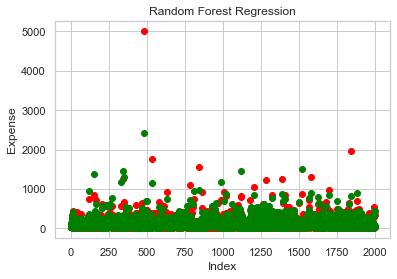

In [336]:
# # Visualising the Random Forest Regression Results  
plt.scatter(resulting.index, resulting['Real Values'], color = 'red')
plt.scatter(resulting.index, resulting['Predicted Values'], color = 'green')
plt.title('Random Forest Regression')
plt.ylabel('Expense')
plt.xlabel('Index')
plt.show()

In [337]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 36.92834516217519
Mean Squared Error (MSE): 9965.327415853526
Root Mean Squared Error (RMSE): 99.82648654467172
Explained Variance Score: 0.7361279731732389
Max Error: 2592.5648000000015
Mean Squared Log Error: 0.48140718066924953
Median Absolute Error: 14.52821750000001
R^2: 0.7361039012561074
